# Statistical analysis to get the significantly associated tokens for attribution score groupings for SAUR cohort

## Read mapping information

In [2]:
import os

import pandas as pd


demoTrainDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_train.csv', sep='\t')
demoTestDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_test.csv', sep='\t')
demoValidateDf = pd.read_csv(os.environ['EHR_DATA_BASE'] + '/blood_pos_cohort_20240614/data/wb_365_wa_1/splits_v1/demographics/mortality_normal_validate.csv', sep='\t')
demoDf = pd.concat([demoTrainDf, demoTestDf, demoValidateDf], ignore_index=True)
demoDf

,person_id,visit_occurrence_id,TYPE,COUNTRY_OF_BIRTH,SEX,Age_Bin,JOURNEY_ID
0,678487,3312694,Emergency,Australia,Male,"(60, 70]",3312694
1,2094045,9199249,Emergency,Australia,Male,"(20, 30]",9199249
2,2107813,9410987,Emergency,Australia,Male,"(50, 60]",9410987
3,2083212,602890,Inpatient,Australia,Female,"(40, 50]",9039437
4,2083212,9039437,Emergency,Australia,Female,"(40, 50]",9039437
...,...,...,...,...,...,...,...
7194,2603535,16588204,Inpatient,Australia,Male,"(60, 70]",16588204
7195,2603535,16709341,Inpatient,Australia,Male,"(60, 70]",16709341
7196,2603535,16651755,Inpatient,Australia,Male,"(60, 70]",16651755
7197,2098616,16872774,Emergency,Australia,Female,"(80, 90]",16872774


In [3]:
import os

mappingDf = pd.read_csv(os.environ['GENOMICS_DATA_BASE'] + '/patient_tube_id_mapping_full.tsv', sep='\t')
mappingDf

,tube_code,PATIENT_ID,db_ID,pt_age,pt_gender,EPISODE_ID,hospital_admission,hospital_discharge,hospital_in_last_year,genome_species,species_reported,contig_number,length,tube_code_duplicate_or_old,date_of_collection,ID_number,location_additional_02,collected_from_original
0,AH19J072,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Escherichia coli,Escherichia coli,92,5131021,NaN,2019-10-30,19-303-0997,A-7EA;HAEM,Blood
1,AH19J074,213972.0,3JNQS,64,Male,12931474.0,2019-10-17,2019-11-29,yes,Streptococcus sp. D19,Streptococcus mitis group,84,2022991,NaN,2019-10-30,19-303-1174,A-7EA;HAEM,Blood Peripheral
2,AH19B003,526238.0,567AE,85,Male,640261.0,2019-02-04,2019-02-07,no,Escherichia coli,Escherichia coli,93,4942915,NaN,2019-02-03,19-034-1596,A-4WB;GMC,Blood
3,AH20A024,788941.0,3YBDS,58,Female,13194824.0,2020-01-16,2020-01-19,no,Escherichia coli,Escherichia coli,110,5149157,NaN,2020-01-16,20-016-2112,S-ED;Emergency,Blood Venous
4,AH20L041,1023735.0,2VJ78,42,Male,14210147.0,2020-12-18,2021-01-05,yes,Staphylococcus aureus,Staphylococcus aureus,46,2735216,NaN,2020-12-16,20-351-2856,Emergency Dept;nan,Blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112,ALF22L076,639020.0,3S6HL,84,Male,17219899.0,2022-12-15,2022-12-20,yes,Streptococcus vestibularis,Streptococcus salivarius group,107,1938627,NaN,2022-12-15,22-349-2150,Ward 4WB,Blood Peripheral
3113,ALF22L089,655404.0,6EWBM,67,Female,NaN,NaN,NaN,NaN,Proteus columbae,Proteus vulgaris,152,3972219,NaN,2022-12-17,22-351-1465,Comm/Amb Clinic,Blood
3114,ALF22L138,2572048.0,YM5PJ,61,Male,NaN,NaN,NaN,NaN,Enterobacter roggenkampii,Enterobacter cloacae complex,66,4876179,NaN,2022-12-27,22-361-0202,Ward 7 East,Hick White Lum
3115,ALF23A102,2054964.0,5DYAH,35,Female,17294287.0,2023-01-12,2023-02-01,yes,Streptococcus constellatus,Streptococcus anginosus group,54,1869828,NaN,2023-01-11,23-011-3305,ICU,Blood Venous


In [4]:
mappedJourneyTubeIdsDf = mappingDf[['tube_code', 'PATIENT_ID', 'EPISODE_ID']].drop_duplicates().merge(
    demoDf[['person_id', 'visit_occurrence_id', 'JOURNEY_ID']],
    how='inner',
    left_on=['PATIENT_ID', 'EPISODE_ID'],
    right_on=['person_id', 'visit_occurrence_id']
).drop(
    columns=['PATIENT_ID', 'EPISODE_ID', 'visit_occurrence_id']
)[['person_id', 'JOURNEY_ID', 'tube_code']].drop_duplicates()
mappedJourneyTubeIdsDf

,person_id,JOURNEY_ID,tube_code
0,50056,13224842,AH20B011
1,62567,12645629,AH19G065
2,138108,14737781,AH21E052
3,211314,13955099,AH20J009
4,211314,13955099,KPN2214
...,...,...,...
512,2084373,16158768,ALF22C004
513,1058066,16759482,ALF22H089
514,2552781,16966609,ALF22J054
515,2638484,16969999,ALF22K143


## Read bed files containing overlapping tokens and attribution scores

In [5]:
import os
import pandas as pd
from pathlib import Path


overlappingFilesDir = Path(os.environ['GENOMICS_DATA_BASE'], 'genome_nlp_tokens', 'overlapping_with_annotations')

overlappingDfList = []
for overlappingFile in os.listdir(overlappingFilesDir):
    df = pd.read_csv(Path(overlappingFilesDir, overlappingFile), sep='\t', names=['contig_id', 'start_position', 'end_position', 'tokens', 'score', 'feature_type', 'id', 'name', 'gene', 'atributes'])
    df['tube_code'] = [overlappingFile.split('_')[0]]*df.shape[0]
    overlappingDfList.append(df)
overlappingDf = pd.concat(overlappingDfList, ignore_index=True)
overlappingDf = overlappingDf.merge(
    mappedJourneyTubeIdsDf,
    how='inner',
    on=['tube_code']
)
overlappingDf = overlappingDf.drop_duplicates()
overlappingDf = overlappingDf[overlappingDf.tokens.apply(lambda x: (len(x) >= 5))].reset_index()
overlappingDf['gene'] = overlappingDf.gene.str.lower()
# overlappingDf = overlappingDf[overlappingDf.feature_type.isin(['CDS', 'ncRNA', 'oriC', 'regulatory_region', 'oriT'])]
overlappingDf

,index,contig_id,start_position,end_position,tokens,score,feature_type,id,name,gene,atributes,tube_code,person_id,JOURNEY_ID
0,0,1,214,219,TGAGGG,-0.000951,CDS,CENNFK_00005,Transposase,NaN,ID=CENNFK_00005;Name=Transposase;locus_tag=CEN...,AH21B039,908851,14408941
1,1,1,220,224,GTTAT,-0.000473,CDS,CENNFK_00005,Transposase,NaN,ID=CENNFK_00005;Name=Transposase;locus_tag=CEN...,AH21B039,908851,14408941
2,3,1,228,233,GAAAGA,-0.000867,CDS,CENNFK_00005,Transposase,NaN,ID=CENNFK_00005;Name=Transposase;locus_tag=CEN...,AH21B039,908851,14408941
3,4,1,234,239,TATTGT,-0.000915,CDS,CENNFK_00005,Transposase,NaN,ID=CENNFK_00005;Name=Transposase;locus_tag=CEN...,AH21B039,908851,14408941
4,5,1,240,245,AGCTGG,-0.001374,CDS,CENNFK_00005,Transposase,NaN,ID=CENNFK_00005;Name=Transposase;locus_tag=CEN...,AH21B039,908851,14408941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14878529,18368428,5,205763,205769,ATGATAT,0.002546,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secret...,pulo,ID=KKIOAG_10525;Name=Prepilin signal peptidase...,AH21K020,2035444,15586881
14878530,18368429,5,205770,205775,CCATCA,0.000022,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secret...,pulo,ID=KKIOAG_10525;Name=Prepilin signal peptidase...,AH21K020,2035444,15586881
14878531,18368430,5,205776,205781,ATTTTT,-0.002056,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secret...,pulo,ID=KKIOAG_10525;Name=Prepilin signal peptidase...,AH21K020,2035444,15586881
14878532,18368431,5,205782,205787,AGGAGG,0.000008,CDS,KKIOAG_10525,Prepilin signal peptidase PulO (type II secret...,pulo,ID=KKIOAG_10525;Name=Prepilin signal peptidase...,AH21K020,2035444,15586881


## Perform chi-square test

### High attribution score

In [6]:
cutoff = overlappingDf.score.mean() + 1 * overlappingDf.score.std()
cutoff

np.float64(0.0033786277485570127)

In [7]:
from scipy import stats

highScoreOverlappingDf = overlappingDf[(overlappingDf.score > cutoff)].tokens.value_counts().reset_index()
lowScoreOverlappingDf = overlappingDf[(overlappingDf.score < cutoff)].tokens.value_counts().reset_index()
mergedOverlappingDf = highScoreOverlappingDf.add_suffix('_hs').merge(
    lowScoreOverlappingDf.add_suffix('_ls'),
    how='inner',
    left_on=['tokens_hs'],
    right_on=['tokens_ls']
)[['tokens_hs', 'count_hs', 'count_ls']].rename(columns={'tokens_hs': 'tokens'})

mergedOverlappingDf['proportion_ls'] = mergedOverlappingDf.count_ls/mergedOverlappingDf.count_ls.sum()

mergedOverlappingDf['count_expected'] = mergedOverlappingDf.proportion_ls * mergedOverlappingDf.count_hs.sum()

filteredOverlappingDf = mergedOverlappingDf[(mergedOverlappingDf.count_hs >= 5) & (mergedOverlappingDf.count_ls >= 5)]

chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(filteredOverlappingDf.count_hs, filteredOverlappingDf.count_expected), correction=True)
significant = p < 0.05  # 5% significance level
print(chi2, p, significant)


723806.6986566525 4.164393399797761e-23 True


`The test indicates that the tokens associated with the high score group are significantly different than the rest`

#### Calculate the ratio of count differences

In [8]:
filteredOverlappingDf.loc[:, 'ratio_difference'] = (filteredOverlappingDf.count_hs / filteredOverlappingDf.count_expected)
filteredOverlappingDf

/tmp/ipykernel_11691/2481632118.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filteredOverlappingDf.loc[:, 'ratio_difference'] = (filteredOverlappingDf.count_hs / filteredOverlappingDf.count_expected)


,tokens,count_hs,count_ls,proportion_ls,count_expected,ratio_difference
0,ATGGT,2681,30693,0.002368,516.973846,5.185949
1,TACTT,2037,41667,0.003215,701.813092,2.902482
2,CAATTT,1955,10968,0.000846,184.738186,10.582544
3,TAATTT,1820,18039,0.001392,303.837722,5.990040
4,CATGC,1809,10893,0.000840,183.474932,9.859658
...,...,...,...,...,...,...
1908,TGAGTCA,5,1920,0.000148,32.339289,0.154611
1909,GAATT,5,16065,0.001239,270.588891,0.018478
1910,TTCTCT,5,1822,0.000141,30.688637,0.162927
1911,TACCT,5,17409,0.001343,293.226393,0.017052


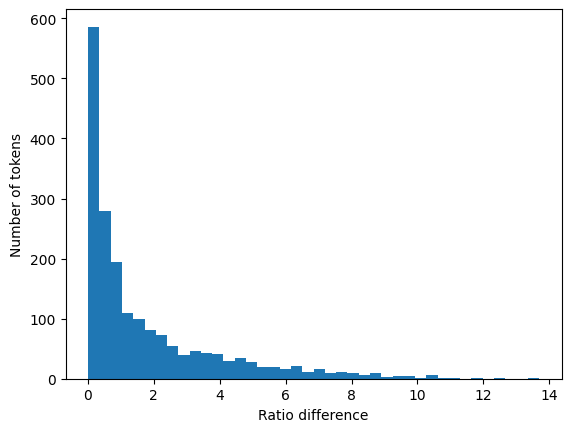

In [9]:
import numpy as np
from matplotlib import pyplot as plt


plt.hist(filteredOverlappingDf.ratio_difference, bins=40)
plt.xlabel("Ratio difference")
plt.ylabel("Number of tokens")
plt.show()

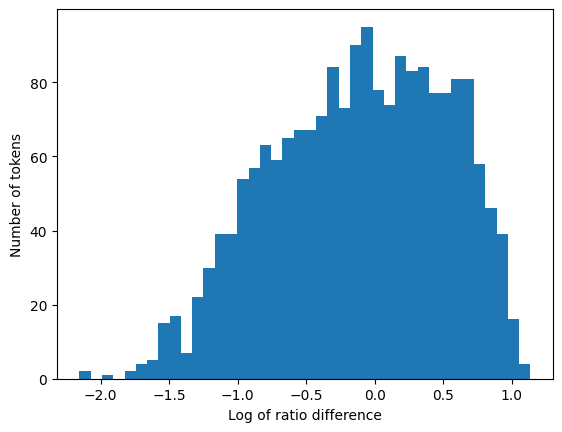

In [10]:
import numpy as np
from matplotlib import pyplot as plt


plt.hist(filteredOverlappingDf.ratio_difference.apply(np.log10), bins=40)
plt.xlabel("Log of ratio difference")
plt.ylabel("Number of tokens")
plt.show()

#### Over represented tokens associated with the high attribution score

In [11]:
overrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference > 4]
overrepresentedTokensDf

/tmp/ipykernel_11691/2494458605.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  overrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference > 4]


,tokens,count_hs,count_ls,proportion_ls,count_expected,ratio_difference
234,TGCCC,254,3761,0.000290,63.347950,4.009601
649,ATCAGA,76,1125,0.000087,18.948802,4.010808
137,AATGAA,367,5425,0.000419,91.375334,4.016401
436,TTGTGT,139,2051,0.000158,34.545771,4.023647
368,AAAATCT,163,2386,0.000184,40.188303,4.055906
...,...,...,...,...,...,...
131,CTGACT,393,2108,0.000163,35.505844,11.068600
574,GCTCAG,93,473,0.000036,7.966918,11.673271
80,TGATTTTT,521,2606,0.000201,43.893847,11.869545
63,GGTCT,571,2677,0.000207,45.089727,12.663638


#### Over represented genes associated with the high attribution score

In [12]:
tempDf = overrepresentedTokensDf.merge(overlappingDf[['tokens', 'feature_type', 'id', 'name', 'gene']], how='inner', on=['tokens'])

tempDf[['tokens', 'feature_type', 'gene', 'name']].groupby(by=['feature_type', 'gene', 'name']).agg('count').reset_index().sort_values(by=['tokens'], ascending=False)[:15]

,feature_type,gene,name,tokens
825,CDS,lys2b,Thioester reductase domain of alpha aminoadipa...,4930
74,CDS,araj,putative arabinose efflux permease AraJ%2C MFS...,4262
1190,CDS,pote,Serine transporter YbeC%2C amino acid:H+ sympo...,4140
387,CDS,ebh,Extracellular matrix-binding protein ebh,3054
141,CDS,bglg,Transcriptional antiterminator,2696
2062,ncRNA,s35,Staphylococcus sRNA 35 (srn_0335),2569
157,CDS,brnq,branched-chain amino acid transport system II ...,2561
72,CDS,arac,AraC-type DNA-binding domain and AraC-containi...,2559
1470,CDS,sasc,LPXTG-anchored repetitive surface protein SasC,2533
1182,CDS,polc,PolC-type DNA polymerase III,2326


#### Under represented tokens associated with the high attribution score

In [13]:
underrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference < 0.1]
underrepresentedTokensDf

/tmp/ipykernel_11691/3318705502.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  underrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference < 0.1]


,tokens,count_hs,count_ls,proportion_ls,count_expected,ratio_difference
1642,ATGAT,8,67861,0.005235,1143.008574,0.006999
1737,ATCGC,6,43435,0.003351,731.592187,0.008201
1562,ACAAT,10,49758,0.003839,838.092875,0.011932
1911,TACCT,5,17409,0.001343,293.226393,0.017052
1773,ACGTT,6,20424,0.001576,344.009182,0.017441
...,...,...,...,...,...,...
1437,TGAAG,13,7894,0.000609,132.961637,0.097773
1747,CCAGCT,6,3617,0.000279,60.922504,0.098486
1762,TTGTCT,6,3583,0.000276,60.349829,0.099420
1788,ACCAAG,6,3573,0.000276,60.181395,0.099699


#### Under represented genes associated with the high attribution score

In [16]:
tempDf = underrepresentedTokensDf.merge(overlappingDf[['tokens', 'feature_type', 'id', 'name', 'gene']], how='inner', on=['tokens'])

tempDf[['tokens', 'feature_type', 'gene', 'name']].groupby(by=['feature_type', 'gene', 'name']).agg('count').reset_index().sort_values(by=['tokens'], ascending=False)[:15]
# gene.value_counts().reset_index()[:5]

,feature_type,gene,name,tokens
825,CDS,lys2b,Thioester reductase domain of alpha aminoadipa...,10018
74,CDS,araj,putative arabinose efflux permease AraJ%2C MFS...,8503
1190,CDS,pote,Serine transporter YbeC%2C amino acid:H+ sympo...,8064
141,CDS,bglg,Transcriptional antiterminator,6648
387,CDS,ebh,Extracellular matrix-binding protein ebh,6457
867,CDS,mdlb,ABC-type multidrug transport system%2C ATPase ...,6042
1473,CDS,sasc,LPXTG-anchored repetitive surface protein SasC,5762
1234,CDS,ptsn,Phosphotransferase system mannitol/fructose-sp...,5391
2068,ncRNA,s35,Staphylococcus sRNA 35 (srn_0335),5342
157,CDS,brnq,branched-chain amino acid transport system II ...,4982


### Low attribution score

In [17]:
cutoff = overlappingDf.score.mean() - 1 * overlappingDf.score.std()
cutoff

np.float64(-0.005416580956594005)

In [18]:
from scipy import stats


highScoreOverlappingDf = overlappingDf[(overlappingDf.score > cutoff)].tokens.value_counts().reset_index()
lowScoreOverlappingDf = overlappingDf[(overlappingDf.score < cutoff)].tokens.value_counts().reset_index()
mergedOverlappingDf = highScoreOverlappingDf.add_suffix('_hs').merge(
    lowScoreOverlappingDf.add_suffix('_ls'),
    how='inner',
    left_on=['tokens_hs'],
    right_on=['tokens_ls']
)[['tokens_hs', 'count_hs', 'count_ls']].rename(columns={'tokens_hs': 'tokens'})

mergedOverlappingDf['proportion_ls'] = mergedOverlappingDf.count_ls/mergedOverlappingDf.count_ls.sum()

mergedOverlappingDf['count_expected'] = mergedOverlappingDf.proportion_ls * mergedOverlappingDf.count_hs.sum()

filteredOverlappingDf = mergedOverlappingDf[(mergedOverlappingDf.count_hs >= 5) & (mergedOverlappingDf.count_ls >= 5)]

chi2, p, dof, expected = stats.chi2_contingency(pd.crosstab(filteredOverlappingDf.count_hs, filteredOverlappingDf.count_expected), correction=True)
significant = p < 0.05  # 5% significance level
print(chi2, p, significant)


2237393.6781196594 0.0 True


#### Calculate the ratio of count differences

In [19]:
filteredOverlappingDf.loc[:, 'ratio_difference'] = (filteredOverlappingDf.count_hs / filteredOverlappingDf.count_expected)

/tmp/ipykernel_11691/3361415802.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filteredOverlappingDf.loc[:, 'ratio_difference'] = (filteredOverlappingDf.count_hs / filteredOverlappingDf.count_expected)


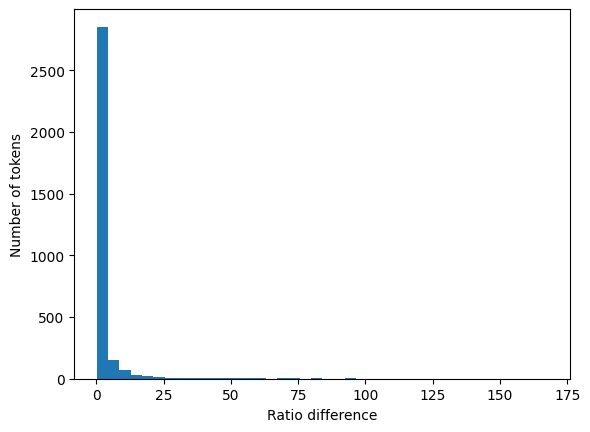

In [20]:
import numpy as np
from matplotlib import pyplot as plt


plt.hist(filteredOverlappingDf.ratio_difference, bins=40)
plt.xlabel("Ratio difference")
plt.ylabel("Number of tokens")
plt.show()

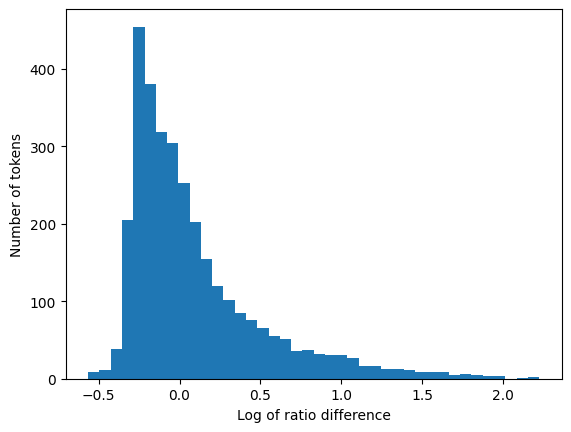

In [21]:
import numpy as np
from matplotlib import pyplot as plt


plt.hist(filteredOverlappingDf.ratio_difference.apply(np.log10), bins=40)
plt.xlabel("Log of ratio difference")
plt.ylabel("Number of tokens")
plt.show()

#### Over represented tokens associated with the low attribution score

In [22]:
overrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference > 4]
overrepresentedTokensDf

/tmp/ipykernel_11691/2494458605.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  overrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference > 4]


,tokens,count_hs,count_ls,proportion_ls,count_expected,ratio_difference
1526,CTGTTT,3182,47,0.000058,794.606897,4.004496
1403,TGATCA,3454,51,0.000063,862.233016,4.005878
2483,CAGACT,1425,21,0.000026,355.037124,4.013665
2312,AACACTG,1698,25,0.000031,422.663243,4.017383
1587,CTGCAT,3057,45,0.000056,760.793838,4.018171
...,...,...,...,...,...,...
130,CACCAC,12876,8,0.000010,135.252238,95.199904
169,ACAGT,12057,7,0.000009,118.345708,101.879487
78,AATTT,15299,7,0.000009,118.345708,129.273805
13,TGATTT,31673,12,0.000015,202.878357,156.118181


#### Over represented genes associated with the low attribution score

In [ ]:
tempDf = overrepresentedTokensDf.merge(overlappingDf[['tokens', 'feature_type', 'id', 'name', 'gene']], how='inner', on=['tokens'])

tempDf[['tokens', 'feature_type', 'gene', 'name']].groupby(by=['feature_type', 'gene', 'name']).agg('count').reset_index().sort_values(by=['tokens'], ascending=False)[:15]

,feature_type,gene,name,tokens
825,CDS,lys2b,Thioester reductase domain of alpha aminoadipa...,8460
74,CDS,araj,putative arabinose efflux permease AraJ%2C MFS...,7381
1190,CDS,pote,Serine transporter YbeC%2C amino acid:H+ sympo...,6885
2068,ncRNA,s35,Staphylococcus sRNA 35 (srn_0335),6640
387,CDS,ebh,Extracellular matrix-binding protein ebh,5772
1473,CDS,sasc,LPXTG-anchored repetitive surface protein SasC,5442
141,CDS,bglg,Transcriptional antiterminator,5390
1234,CDS,ptsn,Phosphotransferase system mannitol/fructose-sp...,4704
1317,CDS,rfab,Glycosyltransferase involved in cell wall bisy...,4526
867,CDS,mdlb,ABC-type multidrug transport system%2C ATPase ...,4399


#### Under represented tokens associated with the low attribution score

In [ ]:
underrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference < 0.4]
underrepresentedTokensDf

/tmp/ipykernel_11408/2716558992.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  underrepresentedTokensDf = filteredOverlappingDf.sort_values(by=['ratio_difference'])[filteredOverlappingDf.ratio_difference < 0.4]


,tokens,count_hs,count_ls,proportion_ls,count_expected,ratio_difference
3104,GCTCAG,465,101,0.000125,1707.559503,0.272318
3080,CTGTGG,496,105,0.000130,1775.185622,0.279407
2740,TTTCTTTTTT,1030,218,0.000270,3685.623481,0.279464
3370,GGAGATTTCA,57,12,0.000015,202.878357,0.280957
3263,GTGATCTG,227,47,0.000058,794.606897,0.285676
3284,GCAGGGG,195,38,0.000047,642.448130,0.303526
225,CATGC,10631,2071,0.002569,35013.423072,0.303626
2428,CCCATG,1508,293,0.000364,4953.613211,0.304424
3358,CCCACCTC,79,15,0.000019,253.597946,0.311517
2402,AGTGAC,1549,284,0.000352,4801.454443,0.322611


#### Under represented genes associated with the low attribution score

In [ ]:
tempDf = underrepresentedTokensDf.merge(overlappingDf[['tokens', 'feature_type', 'id', 'name', 'gene']], how='inner', on=['tokens'])

tempDf[['tokens', 'feature_type', 'gene', 'name']].groupby(by=['feature_type', 'gene', 'name']).agg('count').reset_index().sort_values(by=['tokens'], ascending=False)[:15]

,feature_type,gene,name,tokens
699,CDS,lys2b,Thioester reductase domain of alpha aminoadipa...,496
327,CDS,ebh,Extracellular matrix-binding protein ebh,414
62,CDS,araj,putative arabinose efflux permease AraJ%2C MFS...,348
1220,CDS,sasc,LPXTG-anchored repetitive surface protein SasC,344
116,CDS,bglg,Transcriptional antiterminator,278
1064,CDS,pyca,pyruvate carboxylase,262
909,CDS,odha,2-oxoglutarate dehydrogenase E1 component,261
729,CDS,mdlb,ABC-type multidrug transport system%2C ATPase ...,256
792,CDS,mprf,bifunctional lysylphosphatidylglycerol flippas...,254
42,CDS,alas,alanine--tRNA ligase,242
